### The Sunbet 2013 Data provided by [Pfeffer, Hollstein, and Skvoretz (2013)](http://insna.org/PDF/Connections/v34/vol34pfeffer1_web.pdf)
#### 본 노트는 사회연결망 분석 Conference인 INSNA에서 제공한 Data set을 바탕으로 참가자들의 사회 연결망 및 이들의 연구의 Keywords와 Abstract에 대한 Text 분석을 목표로 하고 있습니다.  

In [ ]:
library(xlsx)
library(igraph)
library(dplyr)
library(Matrix)

setwd("C:\\Users\\suengj\\Documents\\MEGA\\career\\data_repo\\insna\\2014_vol34\\dataset")
options(warn=-1)

In [2]:
# read all sheets from excel file to all list (memory = 2.1mb)

sunbelt <- list()
for(i in 1:9){
    sunbelt[[i]] <- read.xlsx("pfeffer_data.xlsx", sheetIndex = i)
}

In [3]:
# how to delete NA.. variables? 
sunbelt[[1]] <- sunbelt[[1]][,c(1:11)]
sunbelt[[6]] <- sunbelt[[6]][,c(1:3)]

In [4]:
# show data summary
for(i in 1:9){
    str(sunbelt[[i]])
}

'data.frame':	768 obs. of  11 variables:
 $ ID               : num  2 5 6 7 8 9 15 17 18 23 ...
 $ Abstract.Title   : Factor w/ 656 levels "\"Friendship\" Networks and Leadership in Online Social Movement Communities: A Comparison of Election Observer"| __truncated__,..: 434 194 359 377 557 111 312 362 473 71 ...
 $ Authors          : Factor w/ 655 levels "Ã–ztaÅŸ, Nail1, Kesgin, Selman S.2",..: 289 598 293 487 131 275 263 597 601 185 ...
 $ Institutions     : Factor w/ 615 levels "1Aarhus University, Aarhus, Denmark, 2Rutgers Business School, Newark, NJ, United States, 3Grenoble Ecole de Ma"| __truncated__,..: 491 458 512 413 222 573 484 255 541 478 ...
 $ SESSION.NEW      : Factor w/ 74 levels "2-Mode Networks",..: 33 19 33 11 27 62 49 17 60 69 ...
 $ Anzahl           : num  15 17 15 6 15 11 6 6 4 6 ...
 $ Session.Organizer: Factor w/ 35 levels "Ã–rjan Bodin",..: 35 35 35 35 8 4 35 35 35 24 ...
 $ Country          : Factor w/ 45 levels "Andorra","Australia",..: 15 45 45 45 23 15 15 4

먼저 sunbelt 내에 있는 데이터를 모두 불러 들이고, 변수를 생성했을 때 NA..로 잡히는 부분을 제거 하였습니다. 일반화된 방식으로 적용하는 게 편할 것 같습니다. 

해당 데이터를 살펴보니

1. Paper Presentation와 관련한 부분인데, ID, Abstract Title, country, Session Title, Session Code, Talk Nr를 바로 사용 할 수 있을 것 같고
2. Poster Presentation에서는 ID, Abstract Title, Country를 바로 사용 할 수 있으며
    + 다만 Poster Presentation의 경우 Author들의 직접적인 interaction이 있다고 생각하기 어렵기 때문에 network를 구성하는데 있어서 제외할 예정입니다. 
3. Keywords에서는 ID, Type, Keywords를 통하여 Keywords 간의 네트워크를 구성 할 수 있으며
    + 데이터 타입 자체가 DL을 하고 있습니다 (UCINET)
        + 이 부분에서는 Paper와 Poster 모두를 고려하여 네트워크를 구성 할 수도 있고
        + Paper only Network / Poster only Network 등으로 구성하여 네트워크를 구성 할 수 있습니다. 
4. Institution에서는 Authors와 Institutions을 특정한 구분점을 찾은 뒤 나누어야 할 것 같습니다 (Coauthor 등에 대한 부분 고려 필요)
    + 추후에 생각을 해 볼 문제입니다. 
5. Index는 Author가 어떠한 Session에 참여했는지를 나타내는 것으로써 참가자들의 전체 네트워크를 구성 할 수 있습니다.
    + Session Code에서 Poster를 제외한 이들은 interaction이 있다는 quasi-network로써 bipartite network를 구성 할 수 있을 것 같습니다. 
6. Abstract는 개별 Paper들의 Abstract입니다. Abstract 자체에 대한 NLP 분석 및 Key words와 매칭을 한 분석을 할 수 있을 것 같습니다.
    + 특히 Abstract를 통하여 핵심이 되는 단어를 구성 할 수 있거나 혹은 Key words의 조합을 통하여 dictionary를 구성한 뒤에 이에 해당하는 단어들과의 매칭 여부를 살펴 볼 수도 있을 것 같습니다. 
7. Session은 Session Code와 관련한 detail한 정보로써 timeline을 구성할 수 있습니다. (time analysis)
    + 본 분석에서는 Session을 day 기준으로만 나누도록 할 예정입니다. 
8. Time Slot은 Session 별 시간대를 구성함으로써 더욱 detail한 timeline을 구성 할 수 있습니다. 
9. Presentation Times는 개별 Presentation에서 Talk Nr과 매칭을 하여 어떠한 사람이 언제 몇 번째로 발표를 하였는지 알 수 있는 정보를 담고 있습니다.


**이상의 정보를 통하여 구해 낼 수 있는 네트워크 자료는**

1. Author들 간의 Network (t = Day1, Day2, Day3, Day4)
    + Panel 구성 
    + Author의 centrality; Network에 대한 다양한 구조 수준의 분석
2. Author들의 Attribution (Institutions, Key words Vector를 통한 연구 관심사) - 다만 split하는데 시간이 걸릴 수 있음
    + 특히 Institutions까지 구분을 할 수 있으면 (1) Author, (2) Institutions, (3) Key words, (4) Abstract, (5) Sessions 를 바탕으로 Institutions에 대한 분석을 할 수 있을 것 같습니다. - 예컨대, 어떠한 Institutions이 어떠한 social networks 이론을 많이 연구하는가 등 
3. Keywords의 Network (time series로 구분을 하는 것이 의미가 있을지 모르겠음) & Keywords를 기반으로 한 network theory와 관련한 dictionary 구성
4. Abstract 내용에 대한 text analysis

정도가 있습니다. 

다만 이 자료에서는 tie formation 등과 같은 부분은 할 수 없을 것 같습니다. 뿐만 아니라, 기본적으로 같은 session에 할당되는 actor들의 경우는 비교적 같은 내용을 바탕으로 paper를 작성하였기 때문에 (Session 별로 대주제가 있으며, 이와 관련한 소주제는 Key words로 구성될 것입니다) 이 점을 고려해야 할 것 같습니다.  

***
정리를 하면, 

1. Author's Network (using sunbelt[[5]], sunbelt[[7]], & sunbelt[[8]] dataset)
    - Panel Data
    - Author's Specified Interests
    - Author's Structural Positions - more centralized, his or her research topic would be more generalized one
    - Network Through Same Institutions
    - Network Through Same Sessions
2. Key Words Network (using sunbelt[[1]]$Title, sunbelt[[3]], sunbelt[[6]] dataset)
    - What is the topic most centralized in Sunbelt 2013
    - Key Words Vector
    - Abstract NLP analysis

If split Author/Institutions, (1) author-institution bipartite network, (2) author-keywords bipartite network (based on paper), (3) institution-keyword bipartite network, (4) institution-session bipartite network can be calculated 


따라서 이를 바탕으로 네트워크를 먼저 구성하도록 하겠습니다.

In [5]:
# author-session network
head(sunbelt[[7]],3)
head(sunbelt[[5]],3)

# from the dataset, merge sunbelt[[7]] & sunbelt[[5]] with session.code as key-value

Session.Code,Session.Title,Day,Weekday,Slot,Room,Organizer.s.
we-pm-1/Lecture Hall A,Multi-level Networks Analysis 1,1,Wednesday,we-pm-1,Lecture Hall A,Mark Tranmer/ Johan Koskinen
we-pm-1/Lecture Hall C,Historical Network Research 1,1,Wednesday,we-pm-1,Lecture Hall C,Marten DÃ¼ring/ Martin Stark
we-pm-1/Lecture Hall H,Friendship networks 1,1,Wednesday,we-pm-1,Lecture Hall H,NA


Name,Session.Code
"Aalbers, Rick",sa-am-1/Lecture Hall H
"Aartsen, Marja",we-pm-2/Lecture Hall H
"Abbate, Angela",th-am-1/Lecture Hall C


In [6]:
aut.nt <- merge(x=sunbelt[[5]],y=sunbelt[[7]],by='Session.Code', all.x = TRUE)
head(aut.nt,3)

Session.Code,Name,Session.Title,Day,Weekday,Slot,Room,Organizer.s.
fr-am-1/Lecture Hall A,"Fischbach, Kai",Online Social Networks 2,3,Friday,fr-am-1,Lecture Hall A,NA
fr-am-1/Lecture Hall A,"Donath, Martin",Online Social Networks 2,3,Friday,fr-am-1,Lecture Hall A,NA
fr-am-1/Lecture Hall A,"Hillmann, Robert",Online Social Networks 2,3,Friday,fr-am-1,Lecture Hall A,NA


sunbelt[[5]]와 sunbelt[[7]]을 merge합니다. 5를 기준으로 7을 합치는 방향으로 진행을 합니다. 

In [7]:
# make network data based on Day (Author / Slot / Day (=t))
print(unique(aut.nt$Day))

tail(subset(aut.nt, is.na(aut.nt$Day)),5)

[1]  3 NA  4  5  2  1


,Session.Code,Name,Session.Title,Day,Weekday,Slot,Room,Organizer.s.
633,Poster,"Schoder, Detlef",NA,NA,NA,NA,NA,NA
634,Poster,"Hua, Jenna",NA,NA,NA,NA,NA,NA
635,Poster,"Coromina, Lluis",NA,NA,NA,NA,NA,NA
983,Sat-5pm/Lecture Hall A,"Schaefer, David",NA,NA,NA,NA,NA,NA
1450,Th 5pm/Lecture Hall A,"Padgett, John F.",NA,NA,NA,NA,NA,NA


Day를 합친 결과 1~5일과 NA가 반환이 되었습니다. NA는 Poster로 예상을 했고 (5는 author만을 담고 있으며, Poster의 경우에는 별도로 지정된 time.slot이 없기 때문입니다), 확인 결과 대다수는 Poster이지만, 두 건 (983과 1450 row)의 경우 Session.Code가 오탈자인 것 같습니다.
그러나 sunbelt[[8]]의 내용을 확인해보니, 983과 1450의 경우는 별도로 할당이 된 세션인 것 같습니다. 이들의 경우는 해당 세션에서 단독으로 발표를 하였다고 볼 수 있으며 이는 네트워크 변수를 구성하는데 필요가 없기 때문에 Poster Session과 함께 모두 제외하도록 하겠습니다.

In [80]:
aut.nt <- na.omit(aut.nt) # eliminate all missing values in Day column

# based on the variable (author / Session.code / Day), calculate daily matrix
for(i in NROW(unique(aut.nt$Day))){
  tmp <- subset(aut.nt, aut.nt$Day==i)

  bipart <- spMatrix(length(unique(tmp$Name)),
                     length(unique(tmp$Session.Code)),
                     a <- as.numeric(factor(tmp$Name)),
                     b <- as.numeric(factor(tmp$Session.Code)),
                     x = rep(1,length(as.numeric(tmp$Name))))
  
  row.names(bipart) <- levels(factor(tmp$Name))
  colnames(bipart) <- levels(factor(tmp$Session.Code))
  
  bipart <- as.matrix(bipart) # basic format of incidence data set
  
  bn <- graph.incidence(bipart)
  bn.pr <- bipartite.projection(bn)
  adj <- get.adjacency(bn.pr$proj1,sparse=FALSE,att="weight")
  
  graph <- graph_from_adjacency_matrix(adj,weighted="NULL",mode="undirected",diag=FALSE)
  
}

이제 본격적으로 data를 통하여 네트워크를 구성하도록 하겠습니다.

공통의 Session에 참여한 Author들을 tie가 있다고 생각하면 다음과 같은 타입의 데이터를 생각 할 수 있습니다.

|        | event1 | event2 |
|--------|--------|--------|
| actor1 | 1      | 0      |
| actor2 | 0      | 1      |
| actor3 | 1      | 1      |

actor가 다양하게 존재하는 event에 참여를 할 때마다 해당 event에 1이 코딩되고, 그렇지 않을 경우 0이 코딩됩니다. 즉, X = {actor1, actor2, actor3}와 Y = {event1, event2}라는 두 영역(domain)간의 대응 관계로 이해를 할 수 있습니다. 이렇게 actor (X)와 event (Y) 집합을 연결하는 변들의 꼭지점 모두가 actor와 event 집합에 속하고 있을 때, bipartite graph, 즉 이분-그래프라고 부릅니다. 현재는 actor / event라는 두 개의 집합을 바탕으로 bipartite graph를 구성하였지만, n개의 집합이 존재하고 이들의 분할된 집합들을 어떠한 변들이 모두 연결하고 있다면 이는 곧 n-partite graph라고 부를 수 있습니다. 

사실 아직까지 tripartite graph 이상의 형태를 바탕으로 분석을 한 경영학/사회학 연구는 찾아보지 못했습니다 (찾아보면 어딘가에는 있겠지만..) 어쨌든, 이러한 bipartite graph는 그 자체로도 의미가 있습니다. 현재는 actor가 event에 참석을 하는 상황이기 때문에 actor들이 event에 동시에 참석했을 때 그들의 research에 대한 토론을 나누거나 한다는 사회학적으로 유의미한 교환 관계를 형성 할 수 있다고 생각 할 수 있습니다. 따라서 이러한 incidence를 바탕으로 actor들은 quasi-network를 형성한다고 생각 할 수 있고, 그러한 이유에서 actor 간에 social network를 형성한다고 생각 할 수 있습니다. 

많은 사회분야 연구에서는 bipartite graph 내의 row 혹은 column에 위치한 이들 만이 유의미한 사회학적 관계망을 형성하는 상황만을 상정하고 있습니다. 그러나 bipartite graph의 장점은 서로 다른 영역에 위치하고 있지만, 상호 작용을 하게 되는 경우를 네트워크로 포착 할 수 있다는 점입니다. 다시 말하여, bipartite graph를 통해서 서로 다른 level의 observation을 하나의 네트워크로 구성 할 수 있고 이에 대한 전반적인 구조 분석을 할 수 있습니다.

어쨌거나, 현재 Sunbelt data set의 상황에서는 연구자(actor)들이 발표 session (event)에 참여를 함으로써 연구자 간의 사회 연결 관계를 포착하는 것을 목적으로 합니다. 따라서 제가 위에 작성한 R코드는 다음과 같은 순서로 진행이 됩니다.


1. **i in NROW(unique(aut.nt$Day))** : Day의 uniqueness수만큼 loop를 돌립니다. (1 ~ 5일간 Sunbelt가 진행되었기 때문에 5개의 matrix를 구성 할 수 있습니다)

2. **tmp <- subset(aut.nt, aut.nt$Day==i)** : Day1 ~ Day5 별로 이에 해당하는 연구자와 event에 대한 데이터를 subset하였습니다.

3. **bipart 부터 <- as.matrix(bipart) 부분까지** : 위에서 예시로 든 데이터 타입을 bipartite graph 형태로 변환

4. **이후부터 마지막까지** : Luke, Douglas A. (2015)의 A User's Guide to Network Analysis in R의 126 ~ 133 페이지를 참조하며, igraph package를 기반으로 igraph package 상에서 다양한 네트워크 계산 및 시각화를 위한 데이터 타입으로 변환 (bipartite graph -> adjacency matrix -> graph type으로 변환)
    + bipartite graph는 앞서 설명했던 내용이며,
    + adjacency matrix는 사회 연결망 분석에서 가장 기본이 되는 데이터 n\*n의 정방 행렬을 의미합니다.
    + graph type: igraph package에서 데이터 처리를 할 때 기반이 되는 데이터 타입입니다. 

---
R을 사용하며 statnet, sna, igraph의 패키지를 사용해보았지만, igraph가 보다 대중화되어 있는 패키지 같습니다. 다만 igraph 패키지는 graph라는 list 기반의 독특한 데이터 타입을 구성해냄으로써 계산을 하기 때문에 직관적으로 데이터 구성에 오류가 없는지 알아내기가 쉽지 않다는 단점도 있는 것 같습니다. 보다 자세한 사항은 추후에 R과 관련한 설명에서 igraph 패키지를 다룰 때 적도록 하겠습니다. 

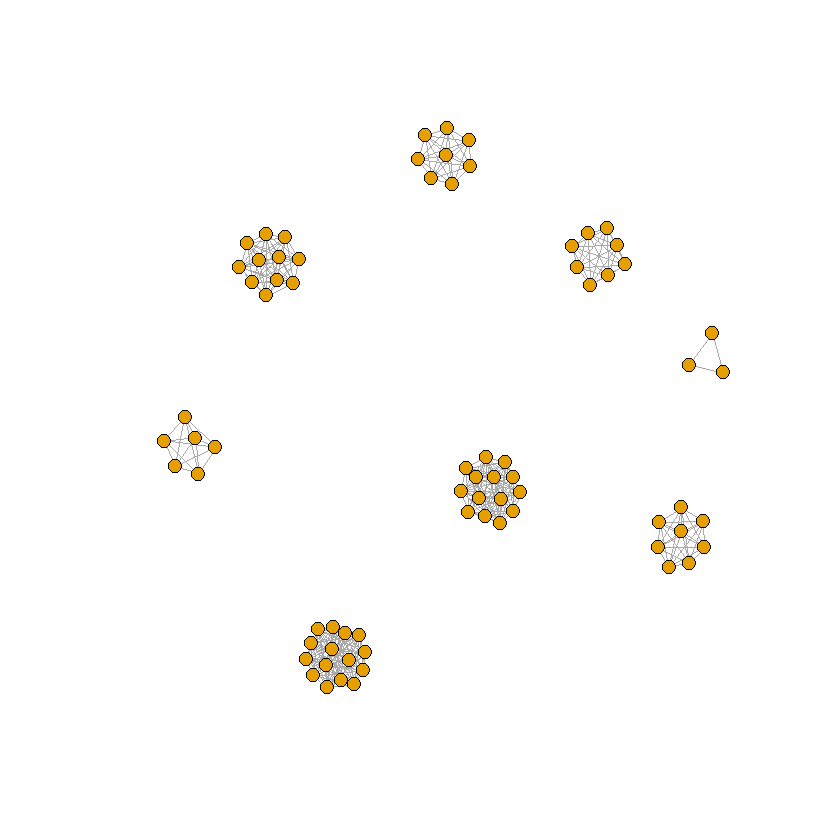

In [91]:
plot(graph, 
     vertex.label=NA, 
     vertex.size=5, 
     vertex.label.dist=100, 
     width=10)

이후 graph라는 기본 단위를 통하여 5일째가 되었을 때 네트워크 상황을 그림으로 그렸습니다. adjacency matrix의 모습이 어땠는지 살펴보지 않았지만, Sunbelt 2013의 5일차에는 모든 author들이 여러 session에 참여하지는 않은 것 같습니다. 그렇기 때문에 같은 session에 참여했던 사람들끼리만 연결 component를 형성하고 있다고 나옵니다. 

**아무래도 시차를 주면서 네트워크를 보는 것은 무의미하다는 판단이 들었습니다**
혹은 time-window를 설정하여 네트워크를 볼 수도 있겠지만 이 역시 크게 무의미 할 것 같습니다. 

In [94]:
  bipart <- spMatrix(length(unique(aut.nt$Name)),
                     length(unique(aut.nt$Session.Code)),
                     a <- as.numeric(factor(aut.nt$Name)),
                     b <- as.numeric(factor(aut.nt$Session.Code)),
                     x = rep(1,length(as.numeric(aut.nt$Name))))
  
  row.names(bipart) <- levels(factor(aut.nt$Name))
  colnames(bipart) <- levels(factor(aut.nt$Session.Code))
  
  bipart <- as.matrix(bipart) # basic format of incidence data set
  
  bn <- graph.incidence(bipart)
  bn.pr <- bipartite.projection(bn)
  adj <- get.adjacency(bn.pr$proj1,sparse=FALSE,att="weight")
  
  graph <- graph_from_adjacency_matrix(adj,weighted="NULL",mode="undirected",diag=FALSE)


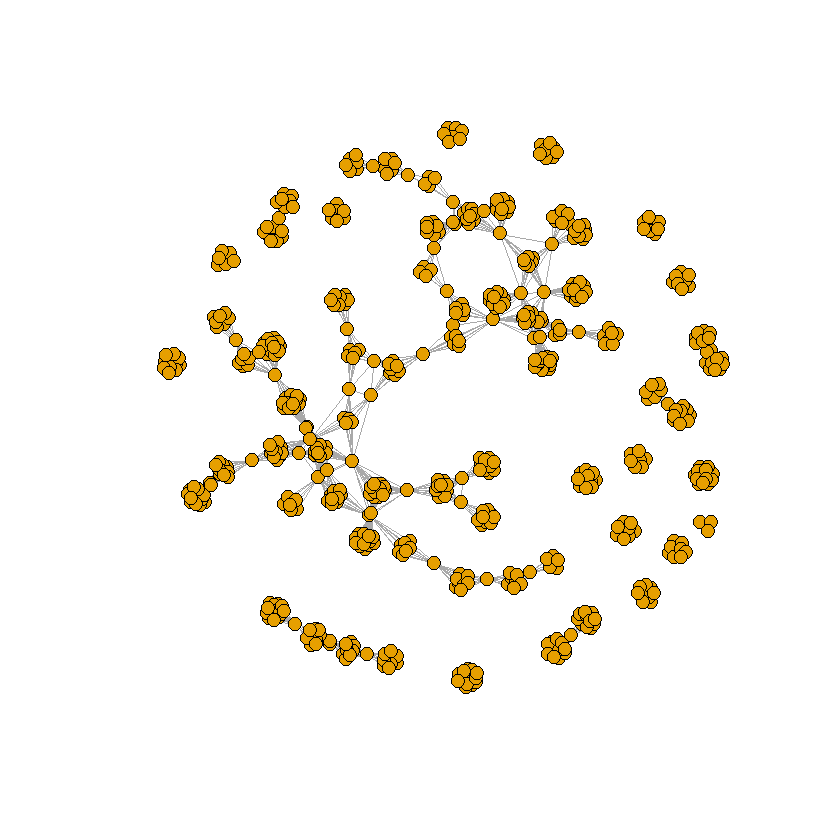

In [95]:
plot(graph, 
     vertex.label = NA, 
     vertex.size=5, 
     vertex.label.dist=1, 
     width=10)

Sunbelt 2013의 전체 event의 네트워크 입니다. (actor (vertex)의 이름을 넣을 경우 그림이 이름에 가려져 생략하였습니다) 

생각보다 Sunbelt 2013에서 학자들은 긴밀한 연결을 하는 것처럼 보이지 않네요. 

이제 저는 다음과 같은 상황이 궁금해졌습니다. 


**"가장 긴밀하게 연결되어 있는 component에서는 어떠한 주제가 가장 많이 언급될까? (Keywords 기반)"**

직관적으로 생각해 볼 수 있는 상황은 다음과 같습니다.

1. 유명한 학자들을 중심으로 네트워크가 형성되는 경우
    + 이러한 상황은 Session의 공동 참여에 따라 네트워크가 형성된다는 측면에서 과연 맞을까 하는 의문이 들기도 합니다.
    
2. 가장 당시 Hot한 주제로 연구를 하는 사람들을 중심으로 네트워크가 형성되는 경우
    + 아무래도 개별 session들은 특정한 topic을 중심으로 모인 사람들입니다. 그러나 어떠한 연구자가 다양한 session에 참여를 했다는 것은 각각의 topic이 상호적으로 연관성을 띄고 있는 경우와
    + 해당 연구자가 다양한 topic에 관심을 갖고 여러 연구를 하고 있는 경우라고 볼 수 있습니다. 
    
    
저는 2번 상황을 보다 구체적으로 파악하기 위하여 연구자들이 자신의 연구에 붙여 놓았던 Keywords를 바탕으로 Research ID - Session - Author - Keywords 네트워크를 그려볼 예정입니다. 방금 그렸던 Author - Session의 Bipartite Network 보다 다양한 그림이 나올 것 같습니다.

Author를 기준으로 Network를 그릴 수 있고, Key words를 기준으로도 Network를 그릴 수 있기 때문입니다. 


---
다음 번에 분석 할 순서는 아래와 같습니다.

1. ID (발표 paper ID)와 Keywords간의 bipartite graph를 형성하여 Keywords 간의 네트워크를 그릴 예정입니다.
2. ID는 각각 고유한 Session과 결합이 되어 있기 때문에 ID별로 네트워크가 그려집니다. 따라서 Paper 간의 Network를 그릴 수 있습니다. 
3. 사실 가장 좋은 것은 Paper를 구성하고 있는 author들을 구분 지은 뒤에 author - session - keywords 간의 관계로 연결되는 네트워크를 구성하는 것이지만, 현재 author들이 하나의 데이터 레코드에 들어가 있어서 이들을 구분하는 작업이 선행되어야 하기 때문에 시간이 걸릴 것 같습니다. 